<a href="https://colab.research.google.com/github/insarov2014/Toronto-Island-Ferry-Ticket-Counts-Forecast/blob/main/SalesCount_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Toronto Ferry Activity

In [1]:
import numpy as np
import pandas as pd
import time
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import sys
sys.path.insert(0, '/content/gdrive/My Drive/Colab Notebooks/WrittenTest_Manitoba')

# Part 1: Initial review of the time series data

# Import the time series data

In [4]:
def load_data(file):
    # generic data processing function
    df = pd.read_csv(file,
                dtype={'_id':int, 'Sales Count': int, 'Sales Count':int},
                parse_dates=['Timestamp'])
    df.sort_values('Timestamp', inplace=True)
    # convert to time-aware
    df.set_index('Timestamp', inplace=True)
    df_daily = df.resample('d').sum()
    # engineer some time features
    df_daily['monthly'] = df_daily.reset_index().Timestamp.dt.month.values
    df_daily['quarter'] = df_daily.reset_index().Timestamp.dt.quarter.values
    return df_daily

In [5]:
file = "/content/gdrive/My Drive/Colab Notebooks/WrittenTest_Manitoba/Toronto Island Ferry Ticket Counts.csv"
df = load_data(file)

In [6]:
# What does the data look like?
df.head()

,_id,Redemption Count,Sales Count,monthly,quarter
Timestamp,,,,,
2015-05-01,985646,1,4,5,2
2015-05-02,0,0,0,5,2
2015-05-03,0,0,0,5,2
2015-05-04,4681600,12,75,5,2
2015-05-05,11332905,537,549,5,2


In [ ]:
df.tail()

,_id,Redemption Count,Sales Count,monthly,quarter
Timestamp,,,,,
2025-06-02,25517,4869,5409,6,2
2025-06-03,19480,5541,5503,6,2
2025-06-04,13080,5806,5423,6,2
2025-06-05,6401,2573,2919,6,2
2025-06-06,1225,4505,4269,6,2


In [ ]:
# Any missing values?
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3690 entries, 2015-05-01 to 2025-06-06
Freq: D
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   _id               3690 non-null   int64
 1   Redemption Count  3690 non-null   int64
 2   Sales Count       3690 non-null   int64
 3   monthly           3690 non-null   int32
 4   quarter           3690 non-null   int32
dtypes: int32(2), int64(3)
memory usage: 144.1 KB


No missing values exist in the data.

In [ ]:
# Any duplicates?
df[df.duplicated()==True]

,_id,Redemption Count,Sales Count,monthly,quarter
Timestamp,,,,,
2015-05-03,0,0,0,5,2
2021-02-22,0,0,0,2,1
2025-01-26,0,0,0,1,1


The 3 records are not duplicates indeed as their time stamps are different.

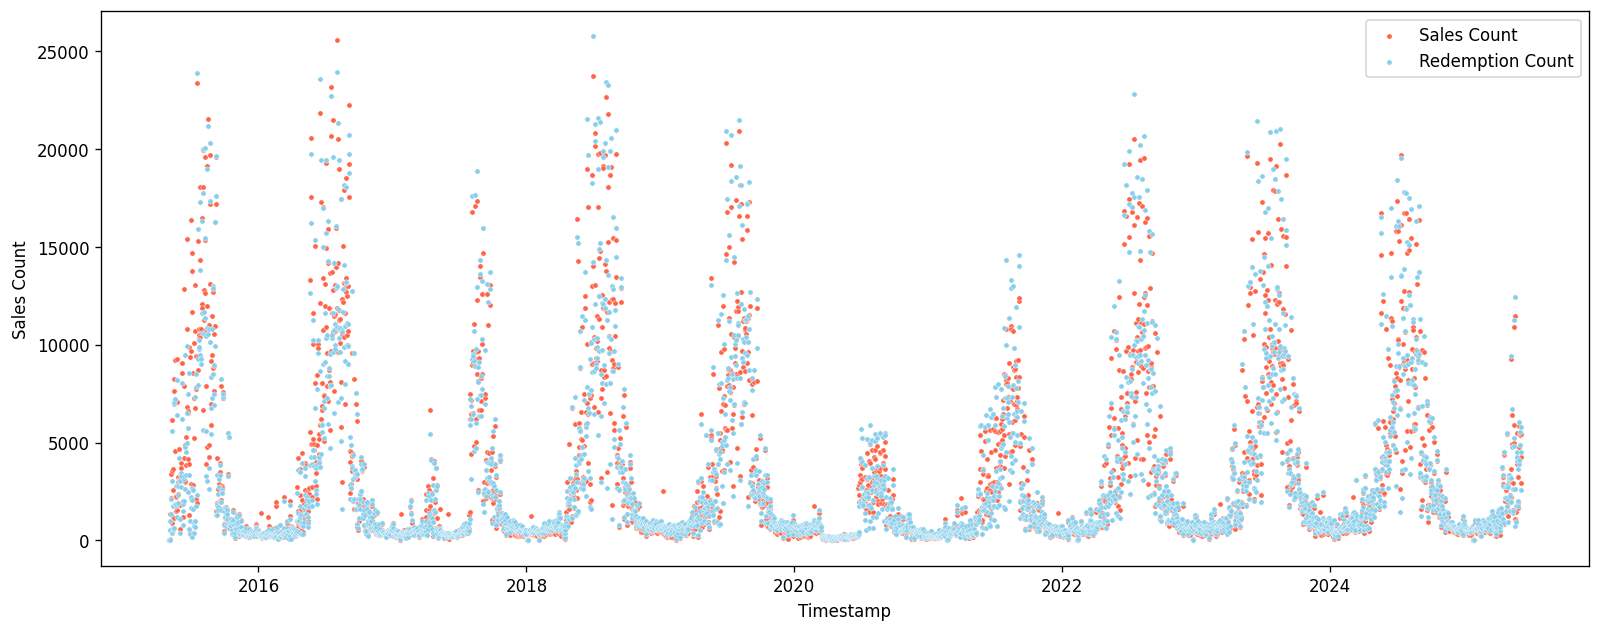

In [ ]:
# Plot the data
plt.rcParams.update({'figure.figsize':(16,6), 'figure.dpi':120})
sns.scatterplot(x=df.index, y=df['Sales Count'], s=10, c='tomato', label='Sales Count')
sns.scatterplot(x=df.index, y=df['Redemption Count'], s=10, c='skyblue', label='Redemption Count')
plt.show()

It seems 'Redemption Count' and	'Sales Count' are correlated. Let's calculate corrlation coefficient.

In [ ]:
print("The correlation coefficient of Sales Count and Redemption Count is:", round(df['Sales Count'].corr(df['Redemption Count']), 2))

The correlation coefficient of Sales Count and Redemption Count is: 0.98


In [ ]:
# Can I consider log transform for Sales Count?
df[df['Sales Count']==0]

,_id,Redemption Count,Sales Count,monthly,quarter
Timestamp,,,,,
2015-05-02,0,0,0,5,2
2015-05-03,0,0,0,5,2
2018-01-04,0,0,0,1,1
2021-02-21,0,0,0,2,1
2021-02-22,0,0,0,2,1
2025-01-26,0,0,0,1,1


The answer to the above question is NO.

In [ ]:
df[df['_id']==0]

,_id,Redemption Count,Sales Count,monthly,quarter
Timestamp,,,,,
2015-05-02,0,0,0,5,2
2015-05-03,0,0,0,5,2
2018-01-04,0,0,0,1,1
2021-02-21,0,0,0,2,1
2021-02-22,0,0,0,2,1
2025-01-26,0,0,0,1,1


# Is the data stationary?

In [ ]:
#The Augmented Dickey-Fuller Test
#Null Hypothesis: Time Series is non-stationary. It gives a time-dependent trend.
#Alternate Hypothesis: Time Series is stationary. In another term, the series doesn’t depend on time.

from statsmodels.tsa.stattools import adfuller

def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Dickey-Fuller test results for columns: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of observations used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("The data is stationary")
    else:
        print("Conclusion:====>")
        print("The null hypothesis cannot be rejected")
        print("The data is not stationary")

In [ ]:
Augmented_Dickey_Fuller_Test_func(df["Sales Count"],'Sales Count')

Dickey-Fuller test results for columns: Sales Count
Test Statistic                   -4.695517
p-value                           0.000086
No Lags Used                     30.000000
Number of observations used    3659.000000
Critical Value (1%)              -3.432138
Critical Value (5%)              -2.862330
Critical Value (10%)             -2.567191
dtype: float64
Conclusion:====>
Reject the null hypothesis
The data is stationary


#Autocorrelation plots

In [ ]:
import statsmodels.api as sm

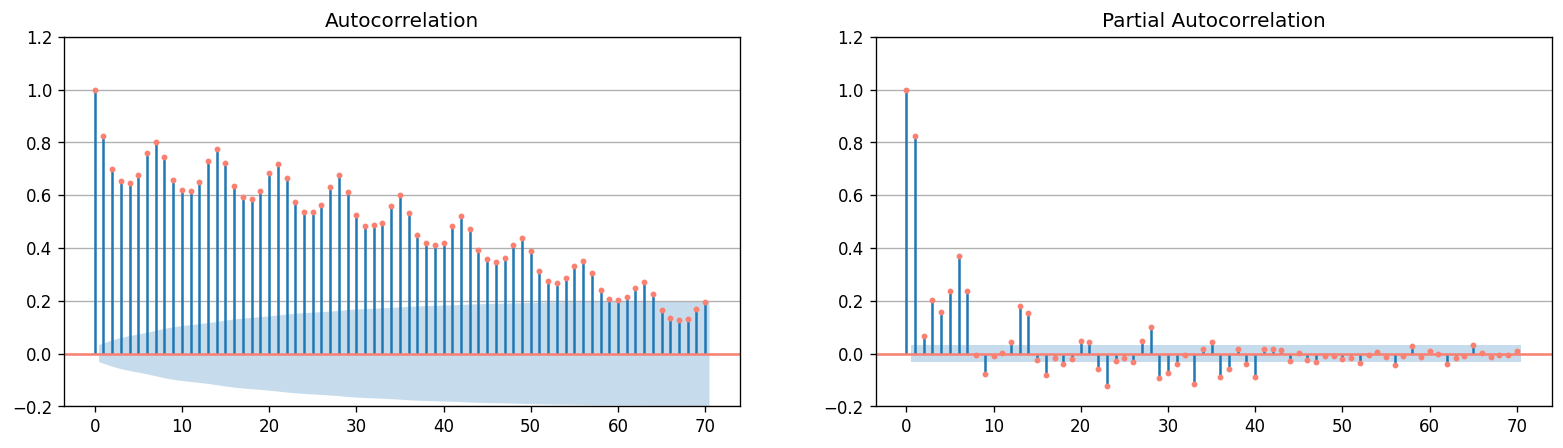

In [ ]:
plt.rcParams.update({'figure.figsize':(16,4), 'figure.dpi':120})
fig, axs = plt.subplots(nrows=1, ncols=2)
sm.graphics.tsa.plot_acf(df["Sales Count"], lags=70, ax=axs[0], color="salmon", markersize=2.5)
axs[0].set_title("Autocorrelation")
axs[0].set_ylim(-0.2, 1.2)
axs[0].grid(axis="y")
sm.graphics.tsa.plot_pacf(df["Sales Count"], lags=70, ax=axs[1], color="salmon", markersize=2.5)
axs[1].set_title('Partial Autocorrelation')
axs[1].set_ylim(-0.2, 1.2)
axs[1].grid(axis="y")
fig.show()

The ACF plot reveals a very slowly decaying pattern, indicating a potential seasonality in the data.

The PACF shows that there is a significant spike at the lags 1 and much lower spikes for the subsequent lags. Thus, an AR(1) model would be feasible for the data.

#Decomposition

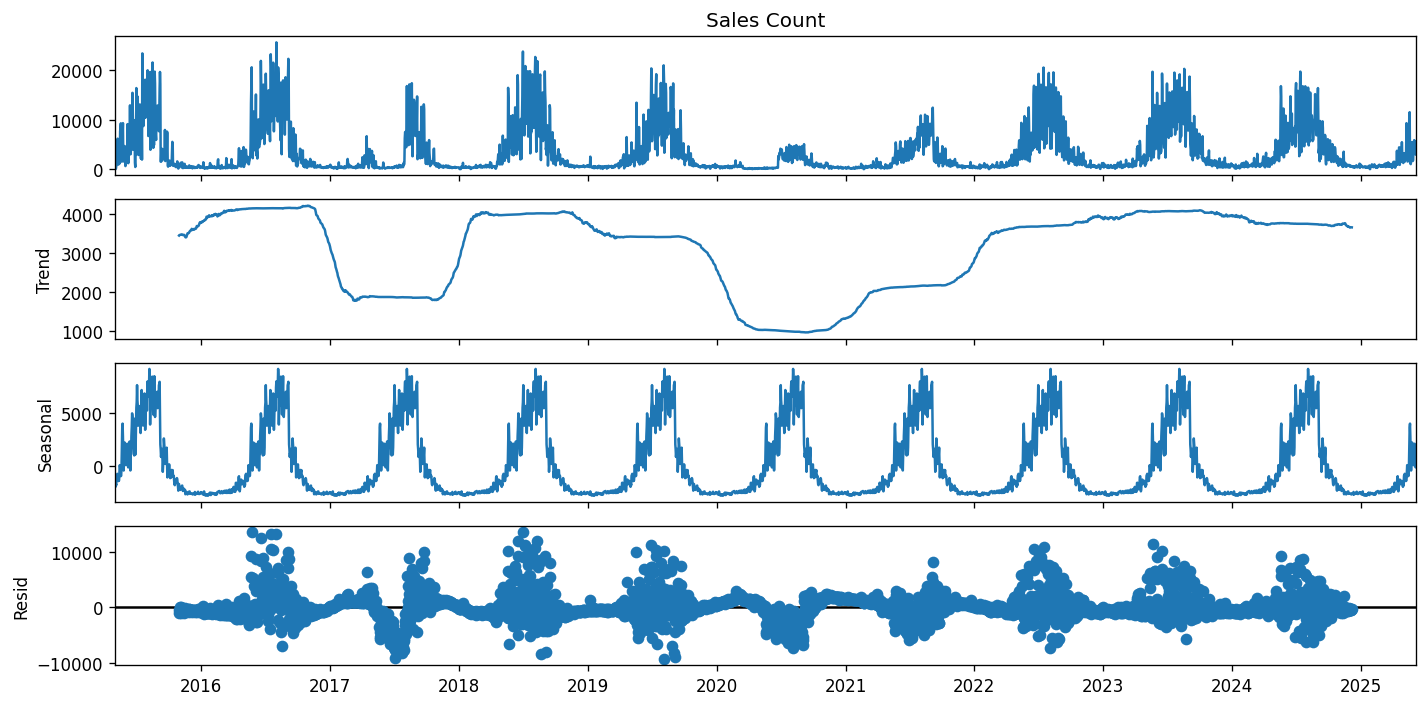

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
plt.rcParams.update({'figure.figsize':(12,6), 'figure.dpi':120})
# I use 'additive' as the data contain some 0s.
a = seasonal_decompose(df["Sales Count"], model="additive", period=365)
a.plot()
plt.show()

The trend doesn't show a consistently upward or downward pattern, the seasonal pattern is significant, and the residuals center at 0 with a seasonal pattern.

# Part 2: Baselines

# The basic models

#Step 1: Split train set and test set for Sales Count data

Since I don't need to tune hyperparameters manually, I don't need a validation set. Thus, I split the whole data into two sets: train set and test set.

In [ ]:
df_new = df['Sales Count'].copy().reset_index()
df_new['unique_id'] = 1
df_new.columns = ['ds', 'y', 'unique_id']
df_new

,ds,y,unique_id
0,2015-05-01,4,1
1,2015-05-02,0,1
2,2015-05-03,0,1
3,2015-05-04,75,1
4,2015-05-05,549,1
...,...,...,...
3685,2025-06-02,5409,1
3686,2025-06-03,5503,1
3687,2025-06-04,5423,1
3688,2025-06-05,2919,1


In [ ]:
tr = df_new.iloc[:-365].copy()
tr

,ds,y,unique_id
0,2015-05-01,4,1
1,2015-05-02,0,1
2,2015-05-03,0,1
3,2015-05-04,75,1
4,2015-05-05,549,1
...,...,...,...
3320,2024-06-02,3384,1
3321,2024-06-03,4868,1
3322,2024-06-04,4642,1
3323,2024-06-05,3362,1


In [ ]:
te = df_new.iloc[-365:].copy()
te

,ds,y,unique_id
3325,2024-06-07,3488,1
3326,2024-06-08,9330,1
3327,2024-06-09,4586,1
3328,2024-06-10,4072,1
3329,2024-06-11,4387,1
...,...,...,...
3685,2025-06-02,5409,1
3686,2025-06-03,5503,1
3687,2025-06-04,5423,1
3688,2025-06-05,2919,1


In [ ]:
print("Min tr Date: " , tr.ds.min())
print("Max tr Date: " , tr.ds.max())
print("Min te Date: " , te.ds.min())
print("Max te Date: " , te.ds.max())

Min tr Date:  2015-05-01 00:00:00
Max tr Date:  2024-06-06 00:00:00
Min te Date:  2024-06-07 00:00:00
Max te Date:  2025-06-06 00:00:00


# Step 2: Try multiple methods of StatsForecast from NIXTLA

In [ ]:
pip install statsforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.8/285.8 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 8.8 MB/s eta 0:00:00


In [ ]:
import statsforecast
from statsforecast.core import StatsForecast

In [ ]:
from statsforecast.models import (
    Naive,
    SeasonalNaive,
    WindowAverage,
    HoltWinters,
    AutoETS,
    ARIMA,
    AutoTheta,
    DynamicTheta,
    DynamicOptimizedTheta,
    Theta,
    OptimizedTheta,
    TBATS,
    AutoTBATS,
    MSTL
)

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import root_mean_squared_error as rmse

In [ ]:
def evaluate_performance(ts_train, ts_test, models, metrics, freq, level, id_col, time_col, target_col, h, metric_df=None):
    if metric_df is None:
        metric_df = pd.DataFrame()  # Initialize an empty DataFrame if not provided

    results = ts_test.copy()

    # Timing dictionary to store train and predict durations
    timing = {}

    for model in models:
        model_name = model.__class__.__name__
        evaluation = {}  # Reset the evaluation dictionary for each model

        # Start the timer for fitting and prediction
        start_time = time.time()

        # Instantiate StatsForecast class
        sf = StatsForecast(
            models=[model],
            freq=freq,
            n_jobs=-1,
            fallback_model=Naive()
        )

        # Efficiently predict without storing memory
        y_pred = sf.forecast(
            h=h,
            df=ts_train,
            id_col=id_col,
            time_col=time_col,
            target_col=target_col,
            level=level,
        )

        # Calculating the duration
        duration = time.time() - start_time
        timing[model_name] = duration

        # Merge prediction results to the original dataframe
        results = results.merge(y_pred, how='left', on=[id_col, time_col])

        ids = ts_train[id_col].unique()
        # Calculate metrics
        for id in ids:
            temp_results = results[results[id_col] == id]
            temp_train = ts_train[ts_train[id_col] == id]
            for metric in metrics:
                metric_name = metric.__name__
                if metric_name == 'mase':
                    evaluation[metric_name] = metric(temp_results[target_col].values,
                                                    temp_results[model_name].values,
                                                    temp_train[target_col].values, seasonality=365)
                else:
                    evaluation[metric_name] = metric(temp_results[target_col].values, temp_results[model_name].values)
            evaluation[id_col] = id
            evaluation['Time Elapsed'] = timing[model_name]

            # Prepare and append this model's results to metric_df
            temp_df = pd.DataFrame(evaluation, index=[0])
            temp_df['Model'] = model_name
            metric_df = pd.concat([metric_df, temp_df], ignore_index=True)

    return results, metric_df

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from itertools import cycle

In [ ]:
def format_plot(fig, legends = None, xlabel="Time", ylabel="Value", title="", font_size=15):
    if legends:
        names = cycle(legends)
        fig.for_each_trace(lambda t:  t.update(name = next(names)))
    fig.update_layout(
            autosize=False,
            width=900,
            height=500,
            title_text=title,
            title={
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
            titlefont={
                "size": 15
            },
            legend_title = None,
            legend=dict(
                font=dict(size=font_size),
                orientation="h",
                yanchor="bottom",
                y=0.98,
                xanchor="right",
                x=1,
            ),
            yaxis=dict(
                title_text=ylabel,
                titlefont=dict(size=font_size),
                tickfont=dict(size=font_size),
            ),
            xaxis=dict(
                title_text=xlabel,
                titlefont=dict(size=font_size),
                tickfont=dict(size=font_size),
            )
        )
    return fig

In [ ]:
import plotly.express as px

def plot_forecast(pred_df, forecast_columns, timestamp_col, forecast_display_names=None):
    if forecast_display_names is None:
        forecast_display_names = forecast_columns
    else:
        assert len(forecast_columns) == len(forecast_display_names)

    mask = ~pred_df[forecast_columns[0]].isnull()
    colors = [c.replace("rgb", "rgba").replace(")", ", <alpha>)") for c in px.colors.qualitative.Dark2]
    act_color = colors[0]
    colors = cycle(colors[1:])
    dash_types = cycle(["dash", "dot", "dashdot"])

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=pred_df[mask][timestamp_col], y=pred_df[mask]['y'],
                             mode='lines', line=dict(color=act_color.replace("<alpha>", "0.3")),
                             name='Actual y'))

    for col, display_col in zip(forecast_columns, forecast_display_names):
        fig.add_trace(go.Scatter(x=pred_df[mask][timestamp_col], y=pred_df.loc[mask, col],
                                 mode='lines', line=dict(dash=next(dash_types), color=next(colors).replace("<alpha>", "1")),
                                 name=display_col))
    return fig

#Naive (Baseline)

In [ ]:
metrics = pd.DataFrame()

results, metrics = evaluate_performance(
    ts_train=tr,
    ts_test=te,
    models=[Naive()],
    metrics=[mape, mae, mse, rmse],
    freq='D',
    level=[],  # Ensure this is correct or adjust as necessary
    id_col='unique_id',
    time_col='ds',
    target_col='y',
    h=len(te),
    metric_df=metrics  # Pass None or an existing DataFrame if you want to append results
)

In [ ]:
results.head(3)

,ds,y,unique_id,Naive
0,2024-06-07,3488,1,4660.0
1,2024-06-08,9330,1,4660.0
2,2024-06-09,4586,1,4660.0


In [ ]:
results.tail(3)

,ds,y,unique_id,Naive
362,2025-06-04,5423,1,4660.0
363,2025-06-05,2919,1,4660.0
364,2025-06-06,4269,1,4660.0


In [ ]:
metrics

,mean_absolute_percentage_error,mean_absolute_error,mean_squared_error,root_mean_squared_error,unique_id,Time Elapsed,Model
0,5.749801e+16,3620.838379,18172470.0,4262.917969,1,0.127884,Naive


In [ ]:
def compare_plot(results, forecast_columns, forecast_display_names, timestamp_col):
    fig = plot_forecast(results, forecast_columns=model_name, forecast_display_names=model_display_name, timestamp_col='ds')
    fig = format_plot(fig, title=f"{model_name[0]}: "\
                      f"mape: {metrics.loc[metrics.Model==model_name[0]][['mean_absolute_percentage_error']].iloc[0].item():.2e} | "\
                      f"mae: {metrics.loc[metrics.Model==model_name[0]][['mean_absolute_error']].iloc[0].item():.2e} | "\
                      f"mse: {metrics.loc[metrics.Model==model_name[0]][['mean_squared_error']].iloc[0].item():.2e} | "\
                      f"rmse: {metrics.loc[metrics.Model==model_name[0]][['root_mean_squared_error']].iloc[0].item():.2e}")
    fig.update_xaxes(type="date", range=["2024-06-07", "2025-06-06"])
    fig.show()

model_name = ['Naive']
model_display_name = ['Naive']
compare_plot(results, model_name, model_display_name, timestamp_col='ds')

# Seasonal Naive

In [ ]:
results, metrics = evaluate_performance(
    ts_train=tr,
    ts_test=te,
    models=[SeasonalNaive(season_length=365)],
    #metrics=[mase, mae, mse, rmse, smape, forecast_bias],
    metrics=[mape, mae, mse, rmse],
    freq='D',
    level=[],  # Ensure this is correct or adjust as necessary
    id_col='unique_id',
    time_col='ds',
    target_col='y',
    h=len(te),
    metric_df=metrics  # Pass None or an existing DataFrame if you want to append results
)

In [ ]:
results.head(3)

,ds,y,unique_id,SeasonalNaive
0,2024-06-07,3488,1,2135.0
1,2024-06-08,9330,1,3421.0
2,2024-06-09,4586,1,12749.0


In [ ]:
results.tail(3)

,ds,y,unique_id,SeasonalNaive
362,2025-06-04,5423,1,4642.0
363,2025-06-05,2919,1,3362.0
364,2025-06-06,4269,1,4660.0


In [ ]:
model_name = ['SeasonalNaive']
model_display_name = ['SeasonalNaive']
compare_plot(results, model_name, model_display_name, timestamp_col='ds')

#WindowAverage

In [ ]:
%%time
results, metrics = evaluate_performance(
    ts_train=tr,
    ts_test=te,
    models=[WindowAverage(window_size = 365)],
    #metrics=[mase, mae, mse, rmse, smape, forecast_bias],
    metrics=[mape, mae, mse, rmse],
    freq='D',
    level=[],  # Ensure this is correct or adjust as necessary
    id_col='unique_id',
    time_col='ds',
    target_col='y',
    h=len(te),
    metric_df=metrics  # Pass None or an existing DataFrame if you want to append results
)

CPU times: user 46.7 ms, sys: 0 ns, total: 46.7 ms
Wall time: 46.7 ms


In [ ]:
results.head(3)

,ds,y,unique_id,WindowAverage
0,2024-06-07,3488,1,3955.057617
1,2024-06-08,9330,1,3955.057617
2,2024-06-09,4586,1,3955.057617


In [ ]:
results.tail(3)

,ds,y,unique_id,WindowAverage
362,2025-06-04,5423,1,3955.057617
363,2025-06-05,2919,1,3955.057617
364,2025-06-06,4269,1,3955.057617


In [ ]:
model_name = ['WindowAverage']
model_display_name = ['WindowAverage']
compare_plot(results, model_name, model_display_name, timestamp_col='ds')

#HoltWinters

In [ ]:
%%time
results, metrics = evaluate_performance(
    ts_train=tr,
    ts_test=te,
    models=[HoltWinters(error_type = 'A', season_length = 365)],
    #metrics=[mase, mae, mse, rmse, smape, forecast_bias],
    metrics=[mape, mae, mse, rmse],
    freq='D',
    level=[],  # Ensure this is correct or adjust as necessary
    id_col='unique_id',
    time_col='ds',
    target_col='y',
    h=len(te),
    metric_df=metrics  # Pass None or an existing DataFrame if you want to append results
)

CPU times: user 8.21 s, sys: 69.4 ms, total: 8.28 s
Wall time: 7.84 s


In [ ]:
results.head(3)

,ds,y,unique_id,HoltWinters
0,2024-06-07,3488,1,4616.648438
1,2024-06-08,9330,1,4531.152832
2,2024-06-09,4586,1,6118.341309


In [ ]:
results.tail(3)

,ds,y,unique_id,HoltWinters
362,2025-06-04,5423,1,4703.294922
363,2025-06-05,2919,1,3538.991211
364,2025-06-06,4269,1,4230.583008


In [ ]:
model_name = ['HoltWinters']
model_display_name = ['HoltWinters']
compare_plot(results, model_name, model_display_name, timestamp_col='ds')

#Auto ETS

In [ ]:
%%time
# Auto ETS
results, metrics = evaluate_performance(
    ts_train=tr,
    ts_test=te,
    models=[AutoETS(model = 'AAA',season_length = 365)],
    #metrics=[mase, mae, mse, rmse, smape, forecast_bias],
    metrics=[mape, mae, mse, rmse],
    freq='D',
    level=[],  # Ensure this is correct or adjust as necessary
    id_col='unique_id',
    time_col='ds',
    target_col='y',
    h=len(te),
    metric_df=metrics  # Pass None or an existing DataFrame if you want to append results
)

CPU times: user 7.8 s, sys: 50.1 ms, total: 7.85 s
Wall time: 7.38 s


In [ ]:
results.head(3)

,ds,y,unique_id,AutoETS
0,2024-06-07,3488,1,4616.648438
1,2024-06-08,9330,1,4531.152832
2,2024-06-09,4586,1,6118.341309


In [ ]:
results.tail(3)

,ds,y,unique_id,AutoETS
362,2025-06-04,5423,1,4703.294922
363,2025-06-05,2919,1,3538.991211
364,2025-06-06,4269,1,4230.583008


In [ ]:
model_name = ['AutoETS']
model_display_name = ['AutoETS']

compare_plot(results, model_name, model_display_name, timestamp_col='ds')

# ARIMA crashed!!!

In [ ]:
# %%time
# results, metrics = evaluate_performance(
#     ts_train=tr,
#     ts_test=te,
#     models=[ARIMA(order = (1,0,0), seasonal_order = (1,0,0), season_length = 365)],
#     metrics=[mape, mae, mse, rmse],
#     freq='D',
#     level=[],  # Ensure this is correct or adjust as necessary
#     id_col='unique_id',
#     time_col='ds',
#     target_col='y',
#     h=len(te),
#     metric_df=metrics  # Pass None or an existing DataFrame if you want to append results
# )

Note: Google Colab doesn't allow me to obtain the result of ARIMA.

# MSTL

In [ ]:
%%time
results, metrics = evaluate_performance(
    ts_train=tr,
    ts_test=te,
    models=[MSTL(season_length = 365)],
    #metrics=[mase, mae, mse, rmse, smape, forecast_bias],
    metrics=[mape, mae, mse, rmse],
    freq='D',
    level=[],  # Ensure this is correct or adjust as necessary
    id_col='unique_id',
    time_col='ds',
    target_col='y',
    h=len(te),
    metric_df=metrics  # Pass None or an existing DataFrame if you want to append results
)

CPU times: user 2.06 s, sys: 10.3 ms, total: 2.07 s
Wall time: 2.11 s


In [ ]:
results.head(3)

,ds,y,unique_id,MSTL
0,2024-06-07,3488,1,4987.347168
1,2024-06-08,9330,1,4433.309082
2,2024-06-09,4586,1,6762.865234


In [ ]:
results.tail(3)

,ds,y,unique_id,MSTL
362,2025-06-04,5423,1,5660.632812
363,2025-06-05,2919,1,4043.972412
364,2025-06-06,4269,1,4724.532715


In [ ]:
model_name = ['MSTL']
model_display_name = ['MSTL']

compare_plot(results, model_name, model_display_name, timestamp_col='ds')

# Theta

In [ ]:
%%time
results, metrics = evaluate_performance(
    ts_train=tr,
    ts_test=te,
    models=[Theta(season_length=365, decomposition_type='additive')],
    #metrics=[mase, mae, mse, rmse, smape, forecast_bias],
    metrics=[mape, mae, mse, rmse],
    freq='D',
    level=[],  # Ensure this is correct or adjust as necessary
    id_col='unique_id',
    time_col='ds',
    target_col='y',
    h=len(te),
    metric_df=metrics  # Pass None or an existing DataFrame if you want to append results
)

CPU times: user 1.12 s, sys: 3.02 ms, total: 1.13 s
Wall time: 1.12 s


In [ ]:
results.head(3)

,ds,y,unique_id,Theta
0,2024-06-07,3488,1,5495.330078
1,2024-06-08,9330,1,5250.313477
2,2024-06-09,4586,1,6912.120117


In [ ]:
results.tail(3)

,ds,y,unique_id,Theta
362,2025-06-04,5423,1,5167.767578
363,2025-06-05,2919,1,4277.811523
364,2025-06-06,4269,1,4949.311035


In [ ]:
model_name = ['Theta']
model_display_name = ['Theta']

compare_plot(results, model_name, model_display_name, timestamp_col='ds')

#TBATS

In [ ]:
%%time
results, metrics = evaluate_performance(
    ts_train=tr,
    ts_test=te,
    models=[TBATS([365])],
    #metrics=[mase, mae, mse, rmse, smape, forecast_bias],
    metrics=[mape, mae, mse, rmse],
    freq='D',
    level=[],  # Ensure this is correct or adjust as necessary
    id_col='unique_id',
    time_col='ds',
    target_col='y',
    h=len(te),
    metric_df=metrics  # Pass None or an existing DataFrame if you want to append results
)

CPU times: user 8.94 s, sys: 669 ms, total: 9.61 s
Wall time: 9.7 s


In [ ]:
results.head(3)

,ds,y,unique_id,TBATS
0,2024-06-07,3488,1,4973.375488
1,2024-06-08,9330,1,4929.055176
2,2024-06-09,4586,1,4888.368164


In [ ]:
results.tail(3)

,ds,y,unique_id,TBATS
362,2025-06-04,5423,1,-3036.550537
363,2025-06-05,2919,1,-3085.283691
364,2025-06-06,4269,1,-3133.684814


In [ ]:
model_name = ['TBATS']
model_display_name = ['TBATS']

compare_plot(results, model_name, model_display_name, timestamp_col='ds')

#Dynamic Optimized Theta

In [ ]:
%%time
results, metrics = evaluate_performance(
    ts_train=tr,
    ts_test=te,
    models=[DynamicOptimizedTheta(season_length=365, decomposition_type="additive")],
    #metrics=[mase, mae, mse, rmse, smape, forecast_bias],
    metrics=[mape, mae, mse, rmse],
    freq='D',
    level=[],  # Ensure this is correct or adjust as necessary
    id_col='unique_id',
    time_col='ds',
    target_col='y',
    h=len(te),
    metric_df=metrics  # Pass None or an existing DataFrame if you want to append results
)

CPU times: user 3.15 s, sys: 14.9 ms, total: 3.17 s
Wall time: 3.2 s


In [ ]:
results.head(3)

,ds,y,unique_id,DynamicOptimizedTheta
0,2024-06-07,3488,1,5495.439453
1,2024-06-08,9330,1,5250.433594
2,2024-06-09,4586,1,6912.251465


In [ ]:
results.tail(3)

,ds,y,unique_id,DynamicOptimizedTheta
362,2025-06-04,5423,1,5171.838379
363,2025-06-05,2919,1,4281.893066
364,2025-06-06,4269,1,4953.403809


In [ ]:
model_name = ['DynamicOptimizedTheta']
model_display_name = ['DynamicOptimizedTheta']
compare_plot(results, model_name, model_display_name, timestamp_col='ds')

# Optimized Theta

In [ ]:
%%time
results, metrics = evaluate_performance(
    ts_train=tr,
    ts_test=te,
    models=[OptimizedTheta(season_length=365, decomposition_type="additive")],
    #metrics=[mase, mae, mse, rmse, smape, forecast_bias],
    metrics=[mape, mae, mse, rmse],
    freq='D',
    level=[],  # Ensure this is correct or adjust as necessary
    id_col='unique_id',
    time_col='ds',
    target_col='y',
    h=len(te),
    metric_df=metrics  # Pass None or an existing DataFrame if you want to append results
)

CPU times: user 2 s, sys: 8.85 ms, total: 2.01 s
Wall time: 2 s


In [ ]:
results.head(3)

,ds,y,unique_id,OptimizedTheta
0,2024-06-07,3488,1,5495.241699
1,2024-06-08,9330,1,5250.216309
2,2024-06-09,4586,1,6912.014648


In [ ]:
results.tail(3)

,ds,y,unique_id,OptimizedTheta
362,2025-06-04,5423,1,5164.488281
363,2025-06-05,2919,1,4274.523438
364,2025-06-06,4269,1,4946.014160


In [ ]:
model_name = ['OptimizedTheta']
model_display_name = ['OptimizedTheta']

compare_plot(results, model_name, model_display_name, timestamp_col='ds')

# Step 3: Comparison

In [ ]:
metrics

,mean_absolute_percentage_error,mean_absolute_error,mean_squared_error,root_mean_squared_error,unique_id,Time Elapsed,Model
0,5.749801e+16,3620.838379,18172470.0,4262.917969,1,0.231272,Naive
1,6.317378e+15,1610.958862,7632263.5,2762.655273,1,0.028113,SeasonalNaive
2,4.879999e+16,3348.520996,17271306.0,4155.875977,1,0.037875,WindowAverage
3,1.400410e+16,1448.809204,5162309.5,2272.071533,1,7.838352,HoltWinters
4,1.400410e+16,1448.809204,5162309.5,2272.071533,1,7.374692,AutoETS
5,1.849514e+16,1677.382568,5558990.0,2357.750977,1,2.104178,MSTL
6,2.250903e+16,1773.107056,5625786.0,2371.874023,1,1.116672,Theta
7,9.792165e+16,6829.882324,53330132.0,7302.748047,1,9.698117,TBATS
8,2.254184e+16,1774.588989,5629668.5,2372.692139,1,3.189958,DynamicOptimizedTheta
9,2.248260e+16,1771.912720,5622667.0,2371.216309,1,1.990038,OptimizedTheta


In [ ]:
metric_styled = metrics.reset_index(drop=True).style.format({
            "mape": "{:.2e}",
            "mae": "{:.2e}",
            "mse": "{:.2e}",
            "rmse": "{:.2e}"}).highlight_min(color='green', subset=['mean_absolute_percentage_error',
                                                                   'mean_absolute_error',
                                                                   'mean_squared_error',
                                                                   'root_mean_squared_error'])
display(metric_styled)

,mean_absolute_percentage_error,mean_absolute_error,mean_squared_error,root_mean_squared_error,unique_id,Time Elapsed,Model
0,57498011386773504.000000,3620.838379,18172470.000000,4262.917969,1,0.231272,Naive
1,6317378275115008.000000,1610.958862,7632263.500000,2762.655273,1,0.028113,SeasonalNaive
2,48799989647802368.000000,3348.520996,17271306.000000,4155.875977,1,0.037875,WindowAverage
3,14004101645860864.000000,1448.809204,5162309.500000,2272.071533,1,7.838352,HoltWinters
4,14004101645860864.000000,1448.809204,5162309.500000,2272.071533,1,7.374692,AutoETS
5,18495144936341504.000000,1677.382568,5558990.000000,2357.750977,1,2.104178,MSTL
6,22509028097654784.000000,1773.107056,5625786.000000,2371.874023,1,1.116672,Theta
7,97921646576271360.000000,6829.882324,53330132.000000,7302.748047,1,9.698117,TBATS
8,22541841647796224.000000,1774.588989,5629668.500000,2372.692139,1,3.189958,DynamicOptimizedTheta
9,22482599016398848.000000,1771.912720,5622667.000000,2371.216309,1,1.990038,OptimizedTheta


Note Holt Winters and AutoETS got the same values for the same metrics, I only consider one of them. Since mape is for comparison for different time series, and recall the data contain many outliers, I would use mean_absolute_error as the metric to decide a chosen model.

I will use Holt Winters as my baseline.

# Part 3: Use Machine Learning Methods

In [ ]:
df.head()

,_id,Redemption Count,Sales Count,monthly,quarter
Timestamp,,,,,
2015-05-01,985646,1,4,5,2
2015-05-02,0,0,0,5,2
2015-05-03,0,0,0,5,2
2015-05-04,4681600,12,75,5,2
2015-05-05,11332905,537,549,5,2


'_id' doesn't provide any useful information, I will drop it.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3690 entries, 2015-05-01 to 2025-06-06
Freq: D
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   _id               3690 non-null   int64
 1   Redemption Count  3690 non-null   int64
 2   Sales Count       3690 non-null   int64
 3   monthly           3690 non-null   int32
 4   quarter           3690 non-null   int32
dtypes: int32(2), int64(3)
memory usage: 144.1 KB


#Feature Engineering

<font color='skyblue'>Temporal embedding

In [7]:
# to create calendar features, the monthly and quarter features were given

df_newFea = df.copy().drop(['_id'], axis=1)

df_newFea['Datetime'] = pd.to_datetime(df_newFea.index,format='%d-%m-%Y %H:%M')
df_newFea['year'] = df_newFea['Datetime'].dt.year
df_newFea['day'] = df_newFea['Datetime'].dt.day
df_newFea['dayofweek_num'] = df_newFea['Datetime'].dt.dayofweek

df_newFea.shape

(3690, 8)

<font color='skyblue'>Time delay embedding

Recall the ACF plot indicates that the current value is strongly related to the historic values, so I create the lag features. I could trace back to lag=7.  

Since the shiftback method will generate NaN, I will impute the group of missing values with the 1st value of 'Sales Count' in the data.

In [8]:
# to create lag features
impute_lags = df_newFea['Sales Count'].iloc[0]
for i in range(1,8):
    df_newFea[f'lag_{i}'] = df_newFea['Sales Count'].shift(i)
    df_newFea[f'lag_{i}'].fillna(impute_lags, inplace=True)

# Rolling window mean
impute_rollingMean = df_newFea['Sales Count'][:7].mean()
df_newFea['rolling_mean'] = df_newFea['Sales Count'].rolling(window=7).mean()
df_newFea['rolling_mean'].fillna(impute_rollingMean, inplace=True)

# Exponentially weighted moving average
df_newFea['ewma'] = df_newFea['Sales Count'].ewm(span=30).mean()

df_newFea.shape

(3690, 17)

In [9]:
df_newFea.head()

,Redemption Count,Sales Count,monthly,quarter,Datetime,year,day,dayofweek_num,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean,ewma
Timestamp,,,,,,,,,,,,,,,,,
2015-05-01,1,4,5,2,2015-05-01,2015,1,4,4.0,4.0,4.0,4.0,4.0,4.0,4.0,593.714286,4.000000
2015-05-02,0,0,5,2,2015-05-02,2015,2,5,4.0,4.0,4.0,4.0,4.0,4.0,4.0,593.714286,1.933333
2015-05-03,0,0,5,2,2015-05-03,2015,3,6,0.0,4.0,4.0,4.0,4.0,4.0,4.0,593.714286,1.245465
2015-05-04,12,75,5,2,2015-05-04,2015,4,0,0.0,0.0,4.0,4.0,4.0,4.0,4.0,593.714286,21.567527
2015-05-05,537,549,5,2,2015-05-05,2015,5,1,75.0,0.0,0.0,4.0,4.0,4.0,4.0,593.714286,141.571184


In [ ]:
df_newFea.tail()

,Redemption Count,Sales Count,monthly,quarter,Datetime,year,day,dayofweek_num,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean,ewma
Timestamp,,,,,,,,,,,,,,,,,
2025-06-02,4869,5409,6,2,2025-06-02,2025,2,0,5845.0,4051.0,4786.0,1890.0,1637.0,3260.0,5468.0,3839.714286,3851.778104
2025-06-03,5541,5503,6,2,2025-06-03,2025,3,1,5409.0,5845.0,4051.0,4786.0,1890.0,1637.0,3260.0,4160.142857,3958.308549
2025-06-04,5806,5423,6,2,2025-06-04,2025,4,2,5503.0,5409.0,5845.0,4051.0,4786.0,1890.0,1637.0,4701.000000,4052.804771
2025-06-05,2573,2919,6,2,2025-06-05,2025,5,3,5423.0,5503.0,5409.0,5845.0,4051.0,4786.0,1890.0,4848.000000,3979.656077
2025-06-06,4505,4269,6,2,2025-06-06,2025,6,4,2919.0,5423.0,5503.0,5409.0,5845.0,4051.0,4786.0,4774.142857,3998.323426


In [ ]:
df_newFea.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3690 entries, 2015-05-01 to 2025-06-06
Freq: D
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Redemption Count  3690 non-null   int64         
 1   Sales Count       3690 non-null   int64         
 2   monthly           3690 non-null   int32         
 3   quarter           3690 non-null   int32         
 4   Datetime          3690 non-null   datetime64[ns]
 5   year              3690 non-null   int32         
 6   day               3690 non-null   int32         
 7   dayofweek_num     3690 non-null   int32         
 8   lag_1             3690 non-null   float64       
 9   lag_2             3690 non-null   float64       
 10  lag_3             3690 non-null   float64       
 11  lag_4             3690 non-null   float64       
 12  lag_5             3690 non-null   float64       
 13  lag_6             3690 non-null   float64       
 14

In [ ]:
df_newFea.columns

Index(['Redemption Count', 'Sales Count', 'monthly', 'quarter', 'Datetime',
       'year', 'day', 'dayofweek_num', 'lag_1', 'lag_2', 'lag_3', 'lag_4',
       'lag_5', 'lag_6', 'lag_7', 'rolling_mean', 'ewma'],
      dtype='object')

#<font color=pink> Assume that we are not given 'Redemption Count' data!

Recall 'Redemption Count' and 'Sales Count' are strongly correlated, it is very easy to build a very powerful predictive model with the help of 'Redemption Count'! However, we would like to compare our new models with the baseline, thus, we assume that we are not given 'Redemption Count' data for the sake of fairness.

'Datetime' will be dropped as its information are stored in 'year', 'monthly',and 'day'.

The target is 'Sales Count'.

I will do standard scaling for these features: 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'rolling_mean', 'ewma'.

No transformation is done for the features: 'monthly', 'quarter', 'year', 'day', 'dayofweek_num'.

Now, I do train-val-test split.

# Train-val-test split

In [10]:
train = df_newFea.iloc[:-730].copy()
train = train.reset_index(drop=True)

val = df_newFea.iloc[-730:-365].copy()
val = val.reset_index(drop=True)

test = df_newFea.iloc[-365:].copy()
test = test.reset_index(drop=True)

In [ ]:
print(f"train: {train.shape}")
print(f"val: {val.shape}")
print(f"test: {test.shape}")

train: (2960, 17)
val: (365, 17)
test: (365, 17)


In [11]:
# Now define X and y

# the X variables
train_set_X = train.drop(['Sales Count', 'Datetime', 'Redemption Count'], axis=1).copy()
val_set_X = val.drop(['Sales Count', 'Datetime', 'Redemption Count'], axis=1).copy()
test_set_X = test.drop(['Sales Count', 'Datetime', 'Redemption Count'], axis=1).copy()

# the Y Variable
train_set_y = pd.DataFrame(train['Sales Count'].copy())
val_set_y = pd.DataFrame(val['Sales Count'].copy())
test_set_y = pd.DataFrame(test['Sales Count'].copy())

In [12]:
train_set_X.shape, val_set_X.shape, test_set_X.shape

((2960, 14), (365, 14), (365, 14))

<font color='salmon'>Pipeline Transformation<font>

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [14]:
# Use min-max scaling here as many outliers exist!
chosen_fea = ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'rolling_mean', 'ewma']
passthrough_fea = [ 'monthly', 'quarter', 'year', 'day', 'dayofweek_num']
target = ['Sales Count']

num_pipeline = Pipeline([
    ('minMax_scaler', MinMaxScaler()),
])

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, chosen_fea),
    ('passthrough', 'passthrough', passthrough_fea),
])

final_train_X = full_pipeline.fit_transform(train_set_X)
final_val_X = full_pipeline.transform(val_set_X)
final_test_X = full_pipeline.transform(test_set_X)

In [ ]:
'''

# y1_pipeline = Pipeline([
#     ('std_scaler', StandardScaler()),
# ])

y1_pipeline = Pipeline([
    ('minMax_scaler', MinMaxScaler()),
])

y2_pipeline = ColumnTransformer([
    ('y', y1_pipeline, target ),
])

final_train_y = y2_pipeline.fit_transform(train_set_y)
final_val_y = y2_pipeline.transform(val_set_y)
final_test_y = y2_pipeline.transform(test_set_y)
'''

In [15]:
pipeline = Pipeline([
       ('minMax_scaler', MinMaxScaler())
   ])
final_train_y = pipeline.fit_transform(train_set_y)
final_val_y = pipeline.transform(val_set_y)
final_test_y = pipeline.transform(test_set_y)


In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=123)
rf_model.fit(final_train_X, final_train_y)

RandomForestRegressor(random_state=123)

In [ ]:
# to build a table for importance score
list_1 = []
list_2 = []
feature_names = chosen_fea + passthrough_fea

for name, score in zip(feature_names, rf_model.feature_importances_):
  list_1.append(name)
  list_2.append(score)

newDict = {'factor':list_1, 'score':list_2}
importance_tbl = pd.DataFrame(newDict).sort_values(by='score', ascending=False)
importance_tbl

,factor,score
7,rolling_mean,0.776053
13,dayofweek_num,0.092536
2,lag_3,0.016995
0,lag_1,0.015401
4,lag_5,0.014828
3,lag_4,0.013737
5,lag_6,0.012461
6,lag_7,0.011857
8,ewma,0.011416
1,lag_2,0.011372


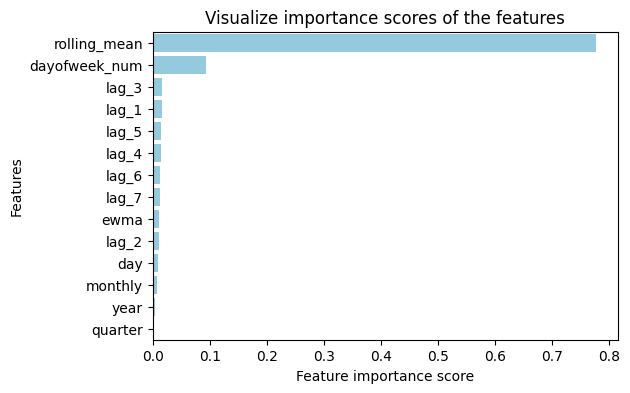

In [ ]:
# to create a bar plot
f, ax = plt.subplots(figsize=(6, 4))
ax = sns.barplot(x='score', y='factor', data=importance_tbl, color='skyblue')
ax.set_title("Visualize importance scores of the features")
ax.set_yticklabels(importance_tbl['factor'])
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

In [ ]:
# # 2nd transformation
# # Drop the 4 features: 'monthly', 'quarter', 'year', 'day'!
# chosen_fea = ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'rolling_mean', 'ewma']
# passthrough_fea = ['dayofweek_num']
# target = ['Sales Count']

# num_pipeline = Pipeline([
#     ('minMax_scaler', MinMaxScaler()),
# ])


# full_pipeline = ColumnTransformer([
#     ('num', num_pipeline, chosen_fea),
#     ('passthrough', 'passthrough', passthrough_fea),
# ])

# final_train_X = full_pipeline.fit_transform(train_set_X)
# final_val_X = full_pipeline.transform(val_set_X)
# final_test_X = full_pipeline.transform(test_set_X)

# y1_pipeline = Pipeline([
#     ('minMax_scaler', MinMaxScaler()),
# ])

# y2_pipeline = ColumnTransformer([
#     ('y', y1_pipeline, target ),
# ])

# final_train_y = y2_pipeline.fit_transform(train_set_y)
# final_val_y = y2_pipeline.transform(val_set_y)
# final_test_y = y2_pipeline.transform(test_set_y)

In [16]:
# Import Libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor

In [17]:
# list of models to be tested
models=[
        ('RandomForestRegressor', RandomForestRegressor(random_state=42)),
        ('SGDRegressor', SGDRegressor(random_state=42)),
        ('Ridge', Ridge(random_state=42)),
        ('Lasso', Lasso(random_state=42)),
        ('ElasticNet', ElasticNet(random_state=42)),
        ('SVR', SVR()),
        ('MLPRegressor', MLPRegressor(random_state=42)),
        ('DecisionTreeRegressor', DecisionTreeRegressor(random_state=42)),
        ('AdaBoostRegressor', AdaBoostRegressor(random_state=42)),
        ('BaggingRegressor', BaggingRegressor(random_state=42)),
        ('ExtraTreesRegressor', ExtraTreesRegressor(random_state=42)),
        ('GradientBoostingRegressor', GradientBoostingRegressor(random_state=42)),
        ('XGBRegressor', XGBRegressor(random_state=42)),
        ('KNeighborsRegressor', KNeighborsRegressor())
]

In [ ]:
%%time
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm, tqdm_gui
from sklearn.model_selection import cross_val_score
import random

## to evaluate the models using cross validation
model_names=[]
model_scores=[]
model_scores_mean=[]
model_scores_std=[]
cv=3
'''
'f1_micro':
Calculate metrics globally by counting the total true positives, false negatives and false positives.
'''
random.seed(42)
for name, model in tqdm(models):
    model_score = cross_val_score(model, final_train_X, final_train_y, scoring='neg_mean_absolute_error', cv=cv)
    model_score = -model_score
    model_names.append(name)
    model_scores.append(model_score)
    model_scores_mean.append(model_score.mean())
    model_scores_std.append(model_score.std())

100%|██████████| 14/14 [00:21<00:00,  1.54s/it]

CPU times: user 22.4 s, sys: 83.1 ms, total: 22.5 s
Wall time: 21.6 s


In [ ]:
model_cv_results = pd.DataFrame({
    'Model':model_names,
    'Mean of MAE Score': model_scores_mean,
    'Std of MAE Score': model_scores_std
    })
round(model_cv_results.sort_values(by='Mean of MAE Score', ascending=True, ignore_index=True),4)

,Model,Mean of MAE Score,Std of MAE Score
0,ExtraTreesRegressor,2.980000e-02,4.700000e-03
1,Ridge,3.030000e-02,5.600000e-03
2,XGBRegressor,3.080000e-02,5.000000e-03
3,RandomForestRegressor,3.140000e-02,4.600000e-03
4,GradientBoostingRegressor,3.210000e-02,4.300000e-03
5,BaggingRegressor,3.370000e-02,4.700000e-03
6,DecisionTreeRegressor,4.460000e-02,4.200000e-03
7,AdaBoostRegressor,5.760000e-02,8.000000e-03
8,KNeighborsRegressor,6.900000e-02,5.500000e-03
9,MLPRegressor,8.360000e-02,1.260000e-02


Extra Trees Regressor is the best model among the 14 candidates. I wil tune the hyperparameters of ExtraTreesRegressor in the next step.

My strategy is to shrink hyperparameters space with the help of Bayesian Optimization, and then find the best set of hyperparameters using Grid Search.

#Bayesian Optimization (hyperopt)

Note: Reproducibility of BO tuning is NOT restricted by np.random.seed(), but the results from multiple executions of BO tuning are similar even though they are not identical. That being said, the readers run the following code snippets and may or may not get the same outcomes, however, the readers will draw the same conclusion as what I documented.

In [ ]:
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import random

In [ ]:
# Classifier:
def objective(space):
  clf = ExtraTreesRegressor(
      n_estimators = int(space['n_estimators']),
      max_depth = int(space['max_depth']),
      #max_samples = space['max_samples'],
      min_samples_split = int(space['min_samples_split']),
      min_samples_leaf = int(space['min_samples_leaf']),
      max_leaf_nodes = int(space['max_leaf_nodes'])
)

  return_val = cross_val_score(clf, final_train_X, final_train_y, cv=3, scoring='neg_mean_absolute_error')
  to_return = -return_val.mean()
  return {'loss':to_return, 'status': STATUS_OK }

1st tuning

In [ ]:
space = {
    'n_estimators': hp.uniform('n_estimators', 0, 150),
    'max_depth': hp.quniform('max_depth', 3, 20, 1),
    #'max_samples': hp.uniform('max_samples', 0.5, 1.0),
    'min_samples_split': hp.quniform('min_samples_split', 2, 20, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1),
    'max_leaf_nodes': hp.quniform('max_leaf_nodes', 10, 100, 1)
    }

In [ ]:
%%time
random.seed = 42
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 3, # set it to 3 here
                        rstate = np.random.default_rng(seed=42),
                        trials = trials)

100%|██████████| 3/3 [00:01<00:00,  1.67trial/s, best loss: 0.0326762461488839]
CPU times: user 1.78 s, sys: 5.2 ms, total: 1.78 s
Wall time: 1.81 s


In [ ]:
best_hyperparams_1st = best_hyperparams
best_hyperparams_1st

{'max_depth': np.float64(16.0),
 'max_leaf_nodes': np.float64(69.0),
 'min_samples_leaf': np.float64(9.0),
 'min_samples_split': np.float64(13.0),
 'n_estimators': np.float64(122.04831114604316)}

2nd tuning

In [ ]:
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm, tqdm_gui
from sklearn.model_selection import cross_val_score
import random

In [ ]:
# 2nd space

space = {
    'n_estimators': hp.uniform('n_estimators', 120, 130),
    'max_depth': hp.quniform('max_depth', 15, 20, 1),
    #'max_samples': hp.uniform('max_samples', 0.5, 1.0),
    'min_samples_split': hp.quniform('min_samples_split', 12, 15, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 7, 10, 1),
    'max_leaf_nodes': hp.quniform('max_leaf_nodes', 65, 75, 1)
    }

In [ ]:
%%time
random.seed = 42
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 3, # set it to 3 here
                        rstate = np.random.default_rng(seed=42),
                        trials = trials)

100%|██████████| 3/3 [00:04<00:00,  1.41s/trial, best loss: 0.03276343646878232]
CPU times: user 4.14 s, sys: 1.58 ms, total: 4.14 s
Wall time: 4.25 s


In [ ]:
best_hyperparams_2nd = best_hyperparams
best_hyperparams_2nd

{'max_depth': np.float64(18.0),
 'max_leaf_nodes': np.float64(67.0),
 'min_samples_leaf': np.float64(9.0),
 'min_samples_split': np.float64(12.0),
 'n_estimators': np.float64(121.46962787285028)}

In [ ]:
best_hyperparams_1st

{'max_depth': np.float64(16.0),
 'max_leaf_nodes': np.float64(69.0),
 'min_samples_leaf': np.float64(9.0),
 'min_samples_split': np.float64(13.0),
 'n_estimators': np.float64(122.04831114604316)}

3rd tuning

In [ ]:
%%time

from sklearn.model_selection import GridSearchCV

param_grid = [{
    'n_estimators': [121, 122],
    'max_depth': [16, 18],
    'min_samples_split': [12, 13],
    'min_samples_leaf': [9],
    'max_leaf_nodes': [67, 69]
}]

ET_grid = ExtraTreesRegressor(random_state=42)

grid_search = GridSearchCV(ET_grid, param_grid, cv=3,
                           scoring='neg_mean_absolute_error',
                           return_train_score=True)

grid_search.fit(final_train_X, final_train_y)

CPU times: user 21 s, sys: 33.7 ms, total: 21.1 s
Wall time: 23.6 s


GridSearchCV(cv=3, estimator=ExtraTreesRegressor(random_state=42),
             param_grid=[{'max_depth': [16, 18], 'max_leaf_nodes': [67, 69],
                          'min_samples_leaf': [9],
                          'min_samples_split': [12, 13],
                          'n_estimators': [121, 122]}],
             return_train_score=True, scoring='neg_mean_absolute_error')

In [ ]:
best_hyperparams_3rd = grid_search.best_params_
best_hyperparams_3rd

{'max_depth': 16,
 'max_leaf_nodes': 69,
 'min_samples_leaf': 9,
 'min_samples_split': 12,
 'n_estimators': 121}

In [ ]:
grid_search.best_score_

np.float64(-0.03257536567495037)

Yes, the best loss is decreasing from 1st tuning through the 3rd tuning!

In [ ]:
my_model = ExtraTreesRegressor(
    n_estimators      = best_hyperparams_3rd['n_estimators'],
    max_depth         = best_hyperparams_3rd['max_depth'],
    min_samples_split = best_hyperparams_3rd['min_samples_split'],
    min_samples_leaf  = best_hyperparams_3rd['min_samples_leaf'],
    max_leaf_nodes    = best_hyperparams_3rd['max_leaf_nodes'],
    random_state      = 42
)

In [ ]:
import joblib

In [ ]:
# to save the model
joblib.dump(my_model, '/content/gdrive/My Drive/Colab Notebooks/WrittenTest_Manitoba/my_model.pkl')

['/content/gdrive/My Drive/Colab Notebooks/WrittenTest_Manitoba/my_model.pkl']

In [ ]:
# to load model
#my_model = joblib.load('/content/gdrive/My Drive/Colab Notebooks/WrittenTest_Manitoba/my_model.pkl')

Learning Curve Function

In [ ]:
# to create a learning curve
def plot_learning_curve(model, X_train, y_train, X_val, y_val, M):
  train_errors, val_errors = [], []
  for m in range(10, X_train.shape[0], M):
    model.fit(X_train[:m], y_train[:m])
    y_train_predict = model.predict(X_train[:m])
    y_val_predict = model.predict(X_val)
    train_errors.append(mean_absolute_error(y_train[:m], y_train_predict))
    val_errors.append(mean_absolute_error(y_val, y_val_predict))

  plt.figure(figsize=(10,4))
  #plt.ylim([0.5, 1])
  plt.title('mean_absolute_error')
  plt.grid(True)
  plt.plot(train_errors, "r-+", linewidth=2, label='train')
  plt.plot(val_errors, "b-", linewidth=3, label='val')
  plt.legend(loc='upper right') # in case labels don't show up
  plt.show()

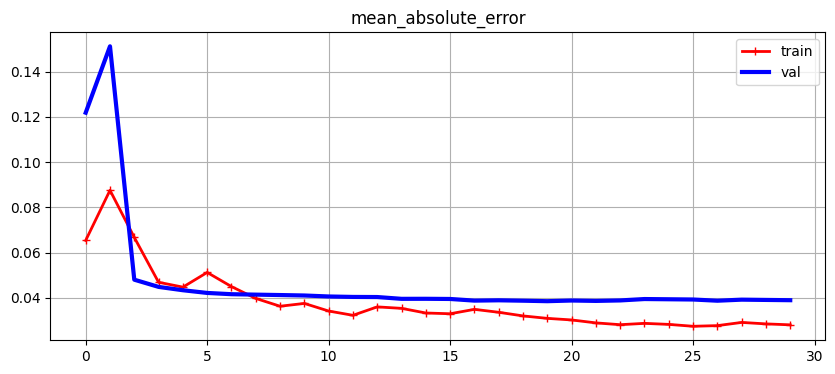

In [ ]:
plot_learning_curve(my_model, final_train_X, final_train_y, final_val_X, final_val_y, M=100)

In [ ]:
val_pred = my_model.predict(final_val_X)

In [ ]:
mean_absolute_error(final_val_y, val_pred)

0.03893560568765501

# Prediction

In [ ]:
# predict on test data
target_pred = my_model.predict(final_test_X)

In [ ]:
target_pred[:10]

array([0.25143885, 0.29715513, 0.30428621, 0.15327085, 0.16150978,
       0.15206619, 0.18750212, 0.27791212, 0.41674023, 0.4657991 ])

In [ ]:
pipeline.fit_transform(train_set_y)

array([[1.56341606e-04],
       [0.00000000e+00],
       [0.00000000e+00],
       ...,
       [1.85225718e-01],
       [1.64510455e-01],
       [1.39573969e-01]])

In [ ]:
# to inverse the predictions to the original scale
target_predInv = pipeline.inverse_transform(target_pred.reshape(-1, 1)).astype(int)

In [ ]:
target_predInv[:10]

array([[ 6433],
       [ 7602],
       [ 7785],
       [ 3921],
       [ 4132],
       [ 3890],
       [ 4797],
       [ 7110],
       [10662],
       [11917]])

In [ ]:
final_test_prediction = test[['Datetime', 'Sales Count']].copy()
final_test_prediction['Sales_Count_predicted'] = target_predInv
final_test_prediction

,Datetime,Sales Count,Sales_Count_predicted
0,2024-06-07,3488,6433
1,2024-06-08,9330,7602
2,2024-06-09,4586,7785
3,2024-06-10,4072,3921
4,2024-06-11,4387,4132
...,...,...,...
360,2025-06-02,5409,3496
361,2025-06-03,5503,3533
362,2025-06-04,5423,3951
363,2025-06-05,2919,4354


In [ ]:
print(f"MAE from Extree Tree Model: {mae(final_test_prediction['Sales Count'], final_test_prediction['Sales_Count_predicted']):.2f}")
print(f"RMSE from Extree Tree Model: {rmse(final_test_prediction['Sales Count'], final_test_prediction['Sales_Count_predicted']):.2f}")
print(f"MSE from Extree Tree Model: {mse(final_test_prediction['Sales Count'], final_test_prediction['Sales_Count_predicted']):.2e}")
print(f"MAPE from Extree Tree Model: {mape(final_test_prediction['Sales Count'], final_test_prediction['Sales_Count_predicted']):.2e}")

MAE from Extree Tree Model: 913.88
RMSE from Extree Tree Model: 1579.30
MSE from Extree Tree Model: 2.49e+06
MAPE from Extree Tree Model: 5.96e+15


# Comparison between Holt Winters(Baseline) and Extra Tree

Prediction of Holt Winters

In [ ]:
%%time
sf_HW = StatsForecast(models=[HoltWinters(error_type = 'A', season_length = 365, alias="Forecast")], freq='D')
sf_HW.fit(df=tr)
Y_hat = sf_HW.forecast(df=tr, h=365, fitted=True, level=[])

full = pd.merge(te, Y_hat, on='ds', how='right')
full = full.drop(['unique_id_x','unique_id_y'], axis=1)
c_list = ['Forecast']
for c in c_list:
    full[c] = full[c].astype(int)
full

CPU times: user 22.8 s, sys: 240 ms, total: 23 s
Wall time: 27.3 s


,ds,y,Forecast
0,2024-06-07,3488,4616
1,2024-06-08,9330,4531
2,2024-06-09,4586,6118
3,2024-06-10,4072,5558
4,2024-06-11,4387,3063
...,...,...,...
360,2025-06-02,5409,5973
361,2025-06-03,5503,5346
362,2025-06-04,5423,4703
363,2025-06-05,2919,3538


In [ ]:
print(f"MAE from Holt Winters Model: {mae(full['y'], full['Forecast']):.2f}")
print(f"RMSE from Holt Winters Model: {rmse(full['y'], full['Forecast']):.2f}")
print(f"MSE from Holt Winters Model: {mse(full['y'], full['Forecast']):.2e}")
print(f"MAPE from Holt Winters Model: {mape(full['y'], full['Forecast']):.2e}")

MAE from Holt Winters Model: 1448.60
RMSE from Holt Winters Model: 2272.04
MSE from Holt Winters Model: 5.16e+06
MAPE from Holt Winters Model: 1.40e+16


Comparison Table

In [ ]:
metrics_comp = pd.DataFrame({'metric':['MAE', 'RMSE', 'MSE', 'MAPE'],
                             'Extree Tree':[f"{mae(final_test_prediction['Sales Count'], final_test_prediction['Sales_Count_predicted']):.2f}",
                                            f"{rmse(final_test_prediction['Sales Count'], final_test_prediction['Sales_Count_predicted']):.2f}",
                                            f"{mse(final_test_prediction['Sales Count'], final_test_prediction['Sales_Count_predicted']):.2e}",
                                            f"{mape(final_test_prediction['Sales Count'], final_test_prediction['Sales_Count_predicted']):.2e}"],
                             'Holt Winters':[f"{mae(full['y'], full['Forecast']):.2f}",
                                            f"{rmse(full['y'], full['Forecast']):.2f}",
                                            f"{mse(full['y'], full['Forecast']):.2e}",
                                            f"{mape(full['y'], full['Forecast']):.2e}"]})
metrics_comp

,metric,Extree Tree,Holt Winters
0,MAE,913.88,1448.60
1,RMSE,1579.30,2272.04
2,MSE,2.49e+06,5.16e+06
3,MAPE,5.96e+15,1.40e+16


It would be easier to find out the comparison of the two model predictions by plotting two plots respectively:

a) Observed sales count and Extra Tree predictions

b) Observed sales count and Holt Winters predictions

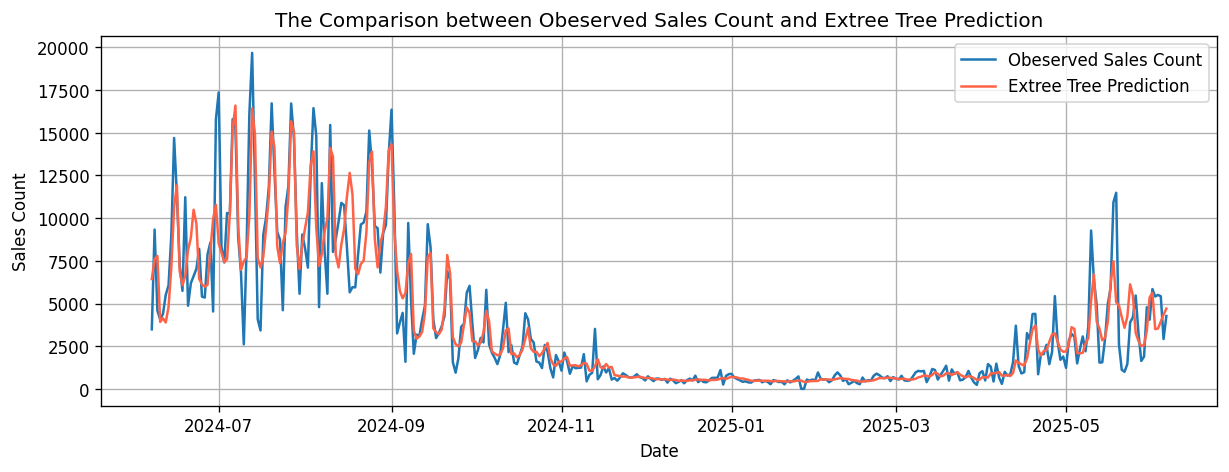

CPU times: user 367 ms, sys: 4.27 ms, total: 371 ms
Wall time: 411 ms


In [ ]:
%%time
plt.figure(figsize=(12, 4))
plt.plot(df.index[-365:], df['Sales Count'].iloc[-365:], label='Obeserved Sales Count')
plt.plot(df.index[-365:], final_test_prediction['Sales_Count_predicted'], color='tomato', label='Extree Tree Prediction')
plt.xlabel('Date')
plt.ylabel('Sales Count')
plt.title('The Comparison between Obeserved Sales Count and Extree Tree Prediction')
plt.legend()
plt.grid(True)
# plt.xticks(rotation=45)
plt.show()

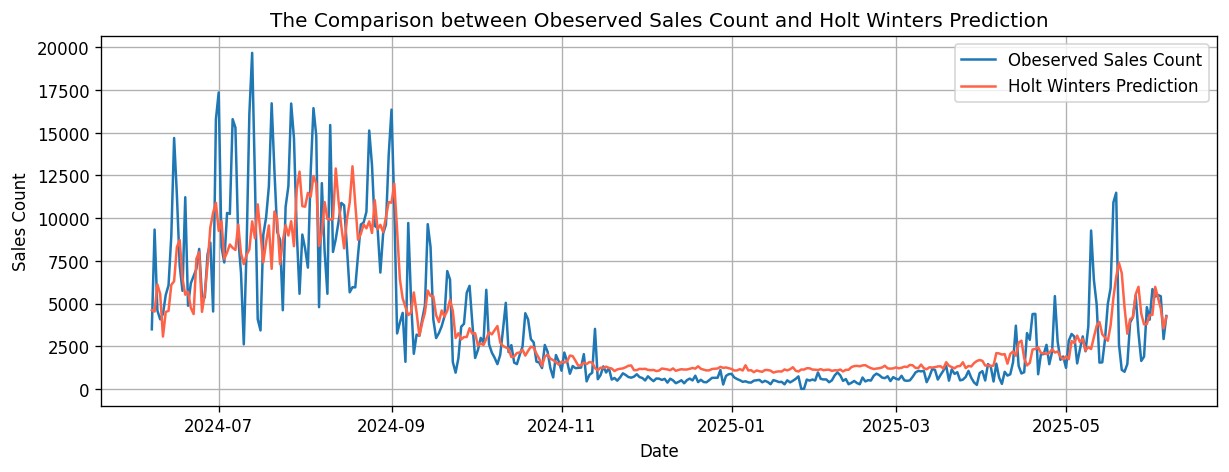

CPU times: user 413 ms, sys: 8.82 ms, total: 422 ms
Wall time: 868 ms


In [ ]:
%%time
plt.figure(figsize=(12, 4))
plt.plot(df.index[-365:], df['Sales Count'].iloc[-365:], label='Obeserved Sales Count')
plt.plot(df.index[-365:], full['Forecast'], color='tomato', label='Holt Winters Prediction')
plt.xlabel('Date')
plt.ylabel('Sales Count')
plt.title('The Comparison between Obeserved Sales Count and Holt Winters Prediction')
plt.legend()
plt.grid(True)
# plt.xticks(rotation=45)
plt.show()

When I compare the 4 metrics from the two models, and compare the two plots, I can tell Extra Tree does a better job than Holt Winters.

my_model is ExtraTreesRegressor(

n_estimators = 121,

max_depth = 16,

min_samples_split = 12,

min_samples_leaf = 9,

max_leaf_nodes = 69,

random_state = 42

).